In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef)
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [3]:
scaler = MinMaxScaler()

def load_dataset(n_components):
    
    digits = datasets.load_digits()

    # 345 ---------------------------------------------
    threes_x = digits["images"][digits["target"]==3]
    fours_x  = digits["images"][digits["target"]==4]
    fives_x  = digits["images"][digits["target"]==5]

    threes_y  = digits["target"][digits["target"]==3]
    fours_y   = digits["target"][digits["target"]==4]
    fives_y = digits["target"][digits["target"]==5]
    
    threes_y[threes_y == 3] = 0
    fours_y[fours_y == 4] = 1
    fives_y[fives_y == 5] = 2

    x_data = np.vstack((threes_x, fours_x))
    x_data = np.vstack((x_data, fives_x))

    y_data = np.hstack((threes_y, fours_y))
    y_data = np.hstack((y_data, fives_y))

    pca = PCA(n_components=n_components)

    x_data = pca.fit_transform(x_data.reshape(x_data.shape[0], 64))
    x_data = x_data/np.amax(x_data)

    x_data, y_data = shuffle(x_data, y_data, random_state=42)

    return x_data, y_data, pca.explained_variance_ratio_.sum()


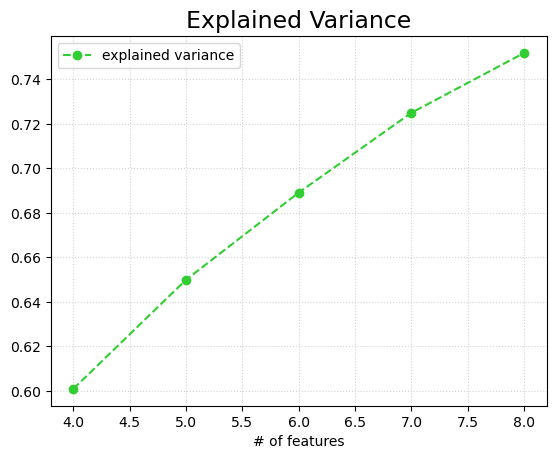

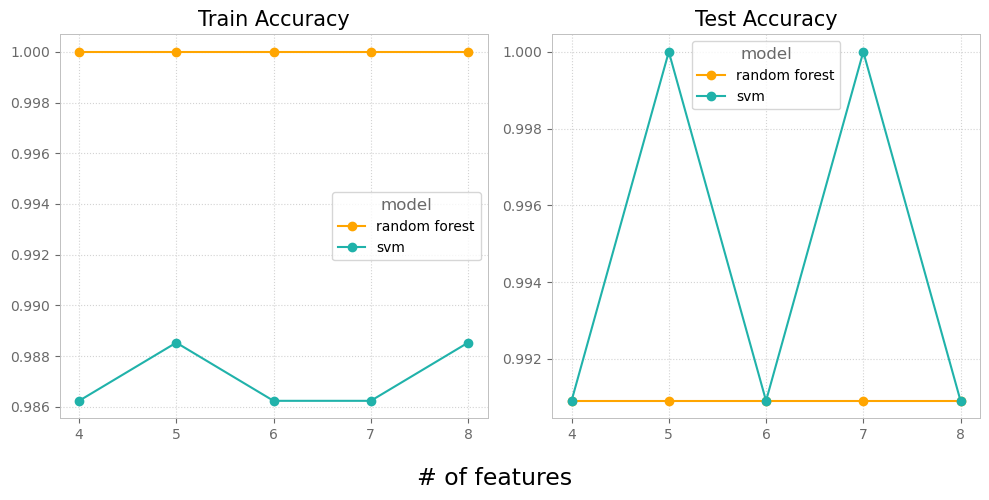

In [7]:
n = np.arange(4, 9, 1)

explained_variance    = []

# Métricas Random Forest
train_accuracy_rf, test_accuracy_rf = [], []
test_precision_rf, test_recall_rf = [], []
test_f1_rf, test_kappa_rf, test_mcc_rf = [], [], []

# Métricas SVM
train_accuracy_svm, test_accuracy_svm = [], []
test_precision_svm, test_recall_svm = [], []
test_f1_svm, test_kappa_svm, test_mcc_svm = [], [], []

for NUM_FEATURES in n:
    X, y, exp_var = load_dataset(NUM_FEATURES)
    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, stratify=y, random_state=42
                                        )

    explained_variance.append(exp_var)

    # === Random Forest ===
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_train_pred_rf = rf_model.predict(X_train)
    y_test_pred_rf = rf_model.predict(X_test)

    train_accuracy_rf.append(accuracy_score(y_train, y_train_pred_rf))
    test_accuracy_rf.append(accuracy_score(y_test, y_test_pred_rf))
    test_precision_rf.append(precision_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_recall_rf.append(recall_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_f1_rf.append(f1_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_kappa_rf.append(cohen_kappa_score(y_test, y_test_pred_rf))
    test_mcc_rf.append(matthews_corrcoef(y_test, y_test_pred_rf))

    # === SVM ===
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    y_train_pred_svm = svm_model.predict(X_train)
    y_test_pred_svm = svm_model.predict(X_test)

    train_accuracy_svm.append(accuracy_score(y_train, y_train_pred_svm))
    test_accuracy_svm.append(accuracy_score(y_test, y_test_pred_svm))
    test_precision_svm.append(precision_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_recall_svm.append(recall_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_f1_svm.append(f1_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_kappa_svm.append(cohen_kappa_score(y_test, y_test_pred_svm))
    test_mcc_svm.append(matthews_corrcoef(y_test, y_test_pred_svm))

# Plot explained variance
plt.figure()
plt.plot(n, np.array(explained_variance), color='limegreen', marker='o', ls='--', label='explained variance')
plt.grid(ls='dotted', color='lightgray')
plt.xlabel("# of features")
plt.title("Explained Variance", fontsize=17)
plt.legend()


# Plot metrics
metrics_rf  = [train_accuracy_rf, test_accuracy_rf]
metrics_svm = [train_accuracy_svm, test_accuracy_svm]
palette = sns.color_palette('hls', 4)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
custom_labels = [f"{ni}" for ni in n]
subplot_titles = ["Train Accuracy", "Test Accuracy"]
axes[0].plot(n, np.array(metrics_rf[0]), color='orange', linestyle="-", marker="o", markersize=6, label="random forest")
axes[0].plot(n, np.array(metrics_svm[0]), color='lightseagreen', linestyle="-", marker="o", markersize=6, label="svm")
axes[1].plot(n, np.array(metrics_rf[1]), color='orange', linestyle="-", marker="o", markersize=6, label="random forest")
axes[1].plot(n, np.array(metrics_svm[1]), color='lightseagreen', linestyle="-", marker="o", markersize=6, label="svm")
for i, ax in enumerate(axes.flat):
    for spine in ax.spines.values():
        spine.set_edgecolor("silver")
        spine.set_linewidth(0.7) 
    ax.set_xticks(range(4,9))
    ax.set_xticklabels(custom_labels, fontsize=10)
    ax.set_title(subplot_titles[i], fontsize=15)
    ax.grid(True, color='lightgrey', ls='dotted')
    ax.legend(title="model", title_fontsize=12) 
    ax.tick_params(axis='both', colors='dimgrey')
    ax.get_legend().get_title().set_color("dimgrey")
fig.supxlabel("# of features", fontsize=17)
plt.tight_layout()
plt.show()
